# Expansion Factor Exploratory Analysis
***
## Selecting Intersection Candidates

Our intersection segments of interest are

* Front/Bathurst to Front/Spadina
* King/Yonge to King/Jarvis
* King/University to King/Yonge

These were chosen as candidates because: 

* Data for these segments exist in the `bluetooth` and `miovision` schema 
* The distances are relatively short
* There are few places of interest down these segments
* There are few streets to turn on, so the volume from the starting point to the ending point is assumably relatively consistent  

In [10]:
# import relevant modules
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [3]:
# connect to database
CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

 The SQL query below grab volume data from November 1st to November 8th. The query exccludes any missing data points in this time frame. Only Lights, Single-Unit Trucks, and Articulated Trucks were counted.   
 
 The `formatter` function simply substitutes intersection id's in to a multiline query string so 3 massive strings don't need to be assigned to variables. 

In [4]:
string = '''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5)) or 

                (intersection_uid = %d  and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; '''


def formatter(string, int1, int2):
    return string % (int2, int1, int1, int2)

#formatter(string, 5, 6)

#frontnew = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)

front = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)
king1 = pandasql.read_sql(pg.SQL(formatter(string,18,20)), con)
king2 = pandasql.read_sql(pg.SQL(formatter(string,15,18)), con)



Separate each intersection into individual dataframes. 

In [5]:
front5 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 5)
front6 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 6)
king15 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 15)
king182 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 18)
king181 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 18)
king20 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 20)

Below are plots of the beginning of the segments (red) compared against the end of the segments (blue). If the through volume is consistent, red and blue lines should greatly overlap. 

It can be seen that for each graph, there is great overlap with some noise for each intersection. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


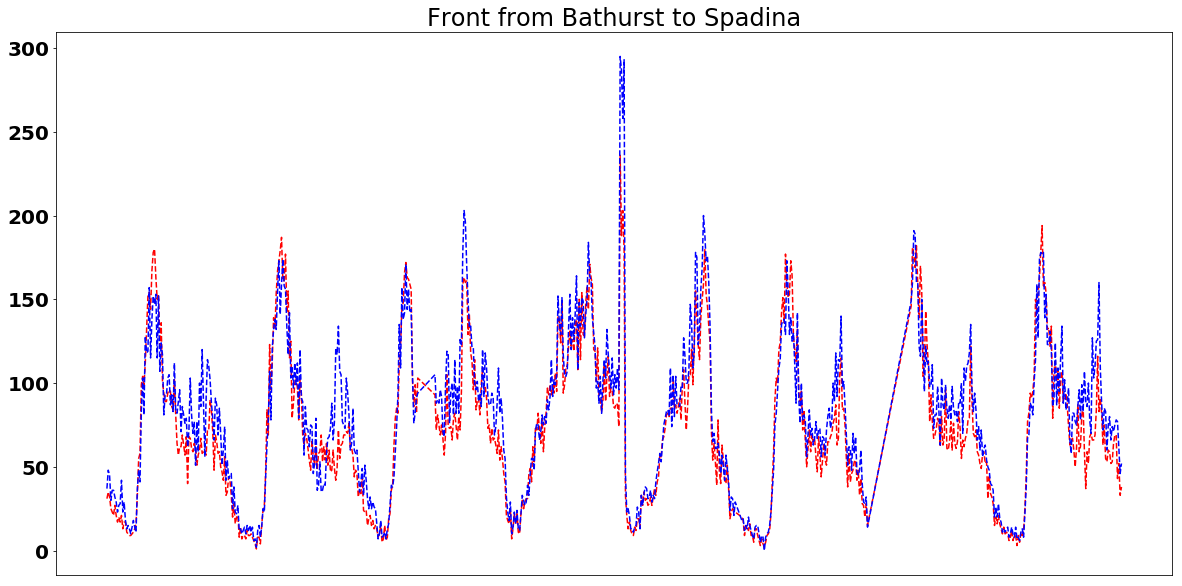

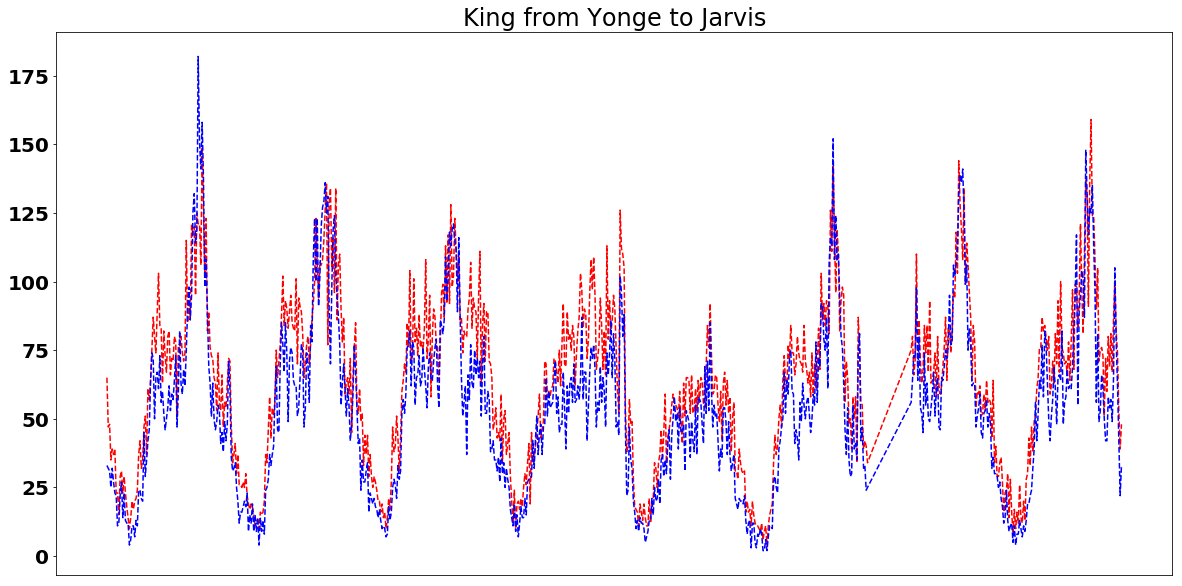

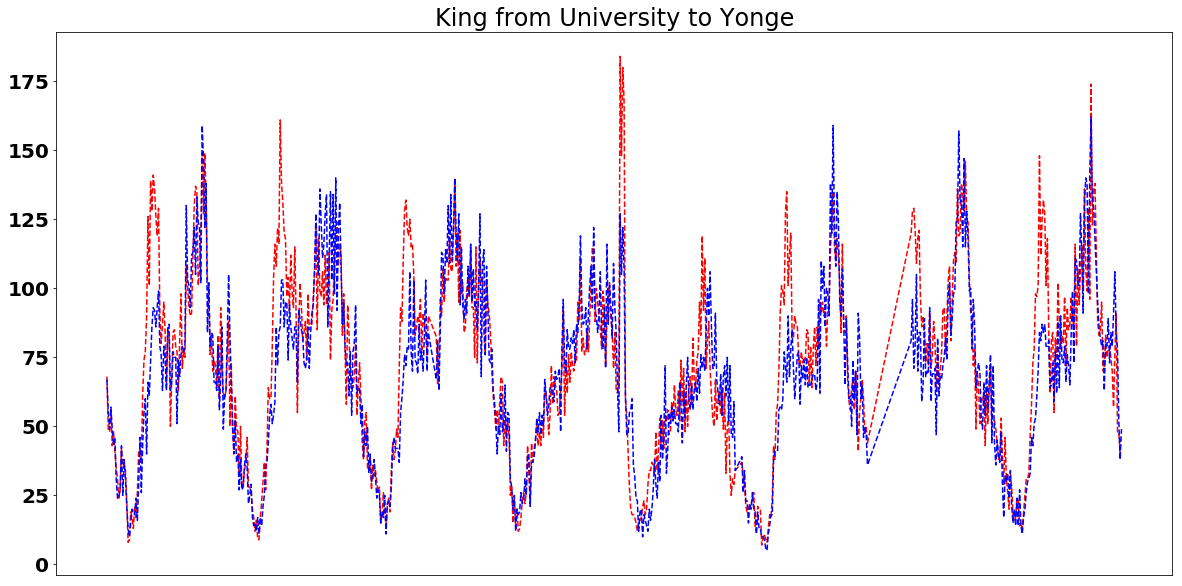

In [27]:
plt.figure(figsize = (20,10))
plt.plot(front5['datetime_bin'], front5['sum'], 'r--', front6['datetime_bin'], front6['sum'], 'b--')
plt.title('Front from Bathurst to Spadina')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (20,10))
plt.plot(king181['datetime_bin'], king181['sum'], 'r--', king20['datetime_bin'], king20['sum'], 'b--')
plt.title('King from Yonge to Jarvis')
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.figure(figsize = (20,10))
plt.plot(king15['datetime_bin'], king15['sum'], 'r--', king182['datetime_bin'], king182['sum'], 'b--')
plt.title('King from University to Yonge')
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.show()

For each segment, the beginning and ending volumes are subtracted, squared, and summated, to give a sort of residual metric we can compare the segments against. It can be seen that King from Yonge to Jarvis has the lowest value, indicating the best volume consistency. 

In [7]:
((front6.reset_index(drop = True)['sum'].subtract(front5.reset_index(drop = True)['sum']))**2).sum(),((king20.reset_index(drop = True)['sum'].subtract(king181.reset_index(drop = True)['sum']))**2).sum(), ((king182.reset_index(drop = True)['sum'].subtract(king15.reset_index(drop = True)['sum']))**2).sum()

(244345.0, 191591.0, 241779.25)

Below are scatter plots for each segment, where the beginning point volumes are compared to ending point volumes. If the volumes are very consistent, the scatter plot should follow closely along the line $y = x$. It can be seen that the first and second plot do this quite well. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


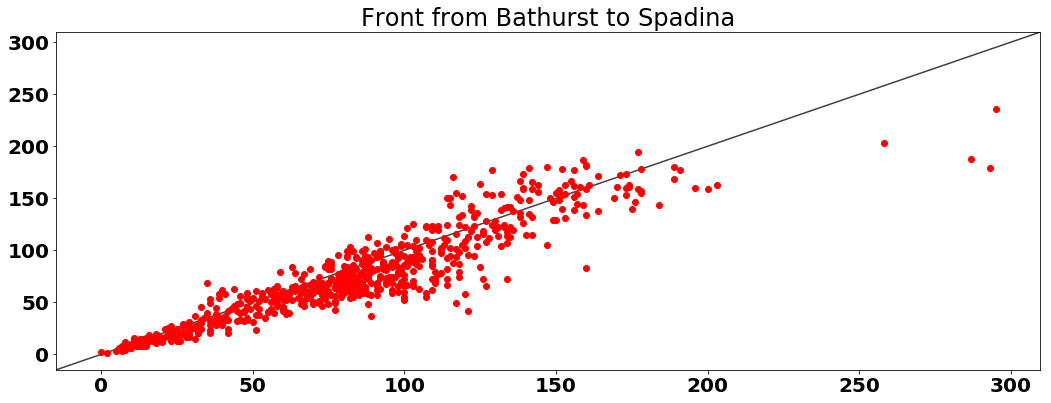

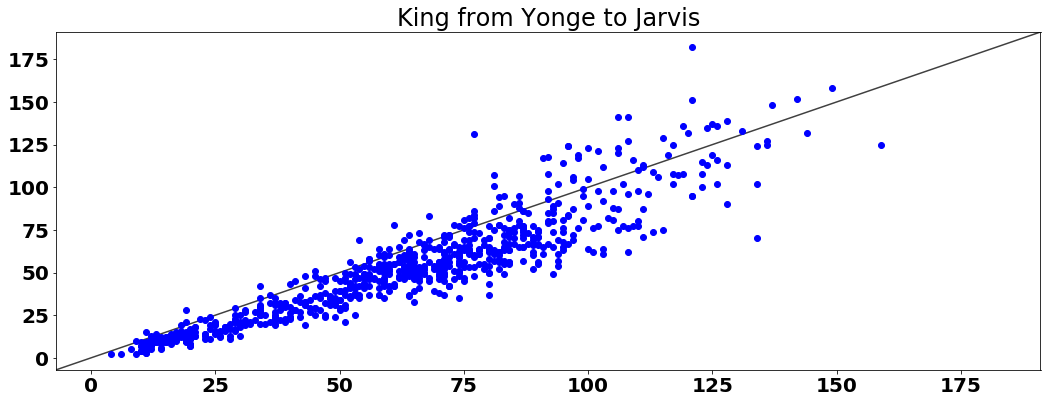

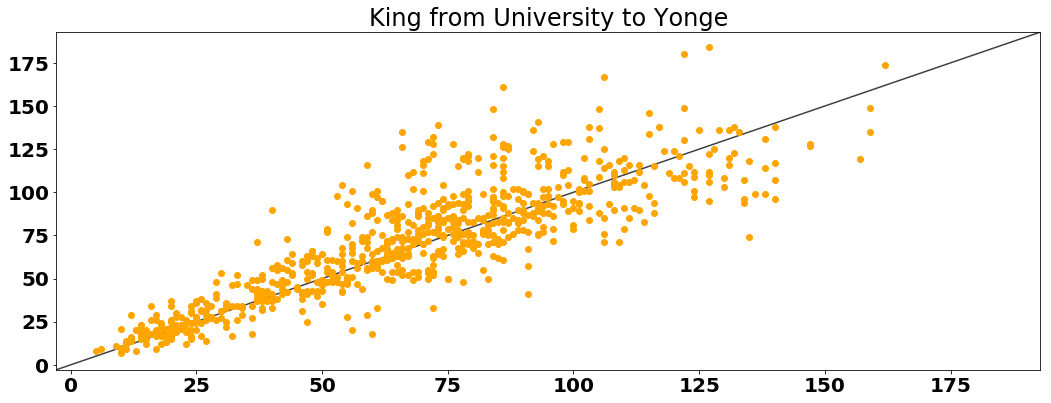

In [12]:
fig, ax = plt.subplots()
ax.scatter(front6.reset_index(drop = True)['sum'], front5.reset_index(drop = True)['sum'], c = 'red')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

plt.title('Front from Bathurst to Spadina')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.tight_layout()

fig, ax = plt.subplots()
ax.scatter(king181.reset_index(drop = True)['sum'], king20.reset_index(drop = True)['sum'], c = 'blue')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

# now plot both limits against eachother
plt.title('King from Yonge to Jarvis')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.tight_layout()


fig, ax = plt.subplots()
ax.scatter(king182.reset_index(drop = True)['sum'], king15.reset_index(drop = True)['sum'], c = 'orange')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

plt.title('King from University to Yonge')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.tight_layout()

plt.show()


In [15]:
sql = pg.SQL('''select datetime_bin, obs from bluetooth.aggr_15min
                        where analysis_id = 1454523
                        and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08'; 
                        ''')

frontbt = pandasql.read_sql(sql, con)
frontbt


,datetime_bin,obs
0,2017-11-01 00:15:00,2
1,2017-11-01 00:30:00,2
2,2017-11-01 01:00:00,1
3,2017-11-01 01:15:00,3
4,2017-11-01 01:30:00,2
5,2017-11-01 01:45:00,1
6,2017-11-01 02:15:00,1
7,2017-11-01 02:30:00,1
8,2017-11-01 02:45:00,2
9,2017-11-01 03:00:00,1


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


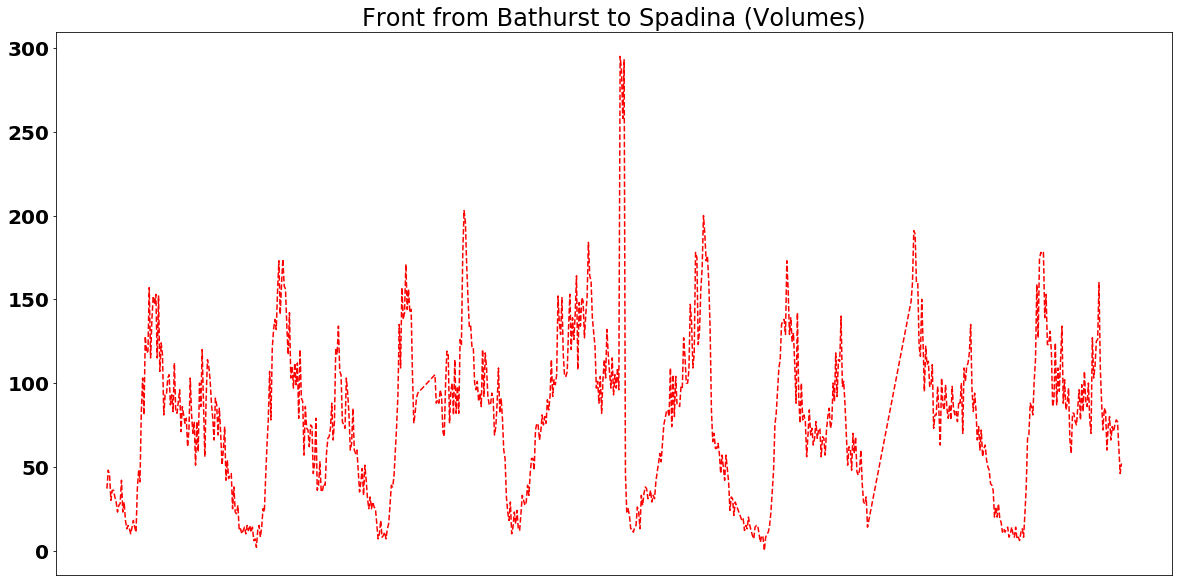

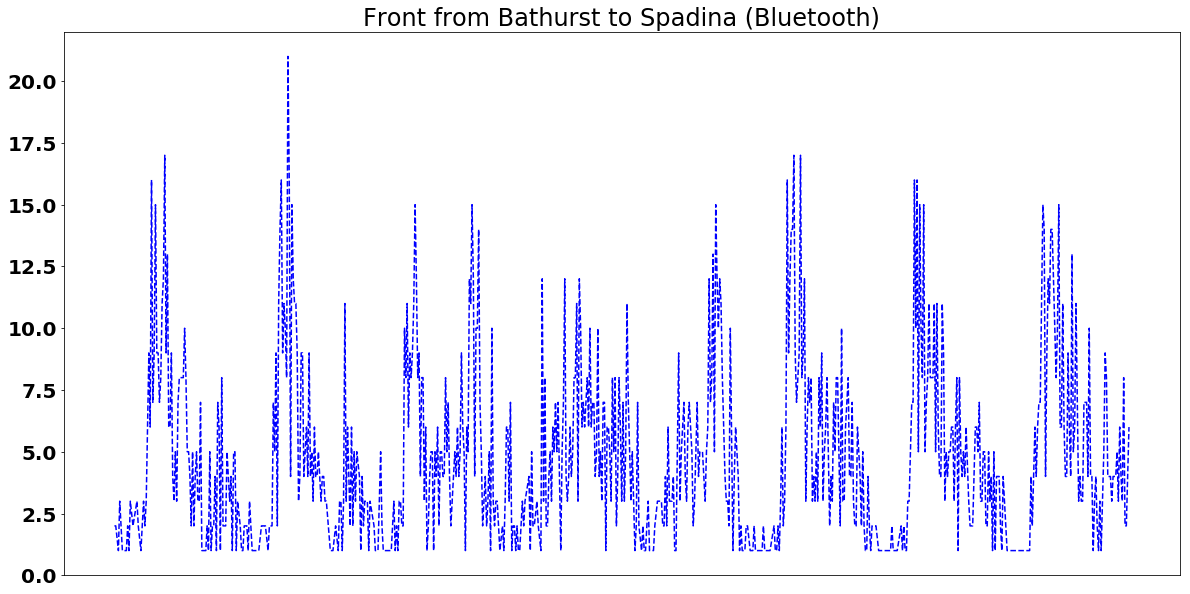

In [26]:
plt.figure(figsize = (20,10))
plt.plot(front6['datetime_bin'], front6['sum'], 'r--')
plt.title('Front from Bathurst to Spadina (Volumes)')
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (20,10))
plt.plot(frontbt['datetime_bin'], frontbt['obs'],'b--')
plt.title('Front from Bathurst to Spadina (Bluetooth)')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])



plt.show()